# Trend analysis in Python

Bruno Montibeller & Holger Virro

Department of Geography

University of Tartu

## Introduction

General introduction of the workshop
* Main goal: using Python to apply trend analysis on NetCDF data
* Trend analysis basics: what it can be used for
* MK test: why it is used for this type of analysis, benefits over other methods

Under the climate change threat, we need to quantify the spatio-temporal trend of temperature and rainfall patterns to understand and evaluate the potential impacts of climate change on ecosystems services, energy fluxes and biogeochemical processes. There are wide range of global or regional scale climate data freely available in a gridded format that can be used in spatio-temporal analysis studies. These data can be derived directly from satellite remote sensing data or based on reanalysis of time series of weather stations data. Additionally, some gridded data are also developed by the combination of time series of remote sensing data and weather stations data.

Different methodologies have combined spatial data sets and nonparametric statistical methods, such as the Mann-Kendall (MK) (Mann, 1945; Kendall, 1957) test, to infer about the temporal trends of climatic variables time series (Atta-ur-Rahman and Dawood, 2017; Jaagus et al., 2017; Silva Junior et al., 2018). As MK is a nonparametric test, it does not require normal distribution of the data, but it does assume no autocorrelation in the time series. The MK test has as null hypothesis that the time series has no trend, and the alternative hypothesis is that it does have a trend (upward or downward). The test first calculates the differences between all pairs of earlier and later data points in the time series. After that, it calculates the variance of these differences, which is posteriorly used to calculate the Z test value. Finally, the statistical significance of the trend is quantified by calculating the probability associated with the normalized Z test. If Z>0, it indicates an increasing trend and if Z<0 it indicates a decreasing trend. Usually, the trends are defined as significant using 95% confidence level. 

In addition to the trend calculation, it is also possible to quantify the magnitude of the trends. The magnitudes can be estimated by using the nonparametric Sen statistic, more specifically, the Sen’s Slope (SS) estimator (Sen Pranab Kumar, 1968), which is given by the median of the slopes of each pair of points. To calculate the Sen’s slope, the times series data is ordered accordingly to the time (as function of time) and a confidence interval is provided for each slope value (same as in the MK test). 

Data description
* Monthly precipitation (and temperature) data for the Baltic states

During the workshop, the participants will learn how to handle raster datasets and apply the MK test and estimate the SS values. We will use the gridded daily precipitation and daily mean temperature products from European Climate Assessment and Dataset (E-OBS version v20.0e) (Cornes et al., 2018) extracted for the three Baltic states (Estonia, Latvia and Lithuania). E-OBS is developed by interpolating climate data from weather stations provided by the national meteorological agencies of the European countries. The product is available at a grid resolution of 0.1° or 0.25°, and covers the period since 1950. For the workshop, we will use the 0.1° resolution dataset (which represents a resolution of about 10 km) from January 2000 until December 2018. ADD HERE LATER IF WE WILL WORK WITH BOTH DATASETS (TEMP AND PREC) AT MONTHLY TIME SCALE.

Tools
* Python libraries xarray, pandas, pymannkendall and matplotlib

List main steps before going on with the coding?
* Reading NetCDF
* Converting it into a Pandas DF
* Grouping data by location and month
* Calculating trend parameters
* Visualizing results

References
* Atta-ur-Rahman, and Dawood, M. (2017). Spatio-statistical analysis of temperature fluctuation using Mann–Kendall and Sen’s slope approach. Clim. Dyn. 48, 783–797. doi:10.1007/s00382-016-3110-y.

* Cornes, R. C., van der Schrier, G., van den Besselaar, E. J. M., and Jones, P. D. (2018). An Ensemble Version of the E-OBS Temperature and Precipitation Data Sets. J. Geophys. Res. Atmos. 123, 9391–9409. doi:10.1029/2017JD028200.

* Jaagus, J., Sepp, M., Tamm, T., Järvet, A., and Mõisja, K. (2017). Trends and regime shifts in climatic conditions and river runoff in Estonia during 1951–2015. Earth Syst. Dyn. 8, 963–976. doi:10.5194/esd-8-963-2017.

* Kendall, M. G. (1957). Rank Correlation Methods. Biometrika 44, 298. doi:10.2307/2333282.

* Mann, H. B. (1945). Non-Parametric Test Against Trend. Econometrica 13, 245–259. Available at: http://www.economist.com/node/18330371?story%7B_%7Did=18330371.

* Sen Pranab Kumar (1968). Estimates of the Regression Coefficient Based on Kendall’s Tau. J. Am. Stat. Assoc. 63, 1379–1389.

* Silva Junior, C. H. L., Almeida, C. T., Santos, J. R. N., Anderson, L. O., Aragão, L. E. O. C., and Silva, F. B. (2018). Spatiotemporal rainfall trends in the Brazilian legal Amazon between the years 1998 and 2015. Water (Switzerland) 10, 1–16. doi:10.3390/w10091220.

## Reading a NetCDF file with xarray

We will start by importing all Python libraries used in this workshop. For data processing and wrangling we are going to use the **[Xarray](http://xarray.pydata.org/en/stable/)**, **[Pandas](https://pandas.pydata.org/)** and **[NumPy](https://numpy.org/)** libraries. **[Matplotlib](https://matplotlib.org/)** will be used for plotting purposes. Trend analysis will be carried out using the **[pyMannKendall](https://pypi.org/project/pymannkendall/)** library.

In [17]:
# Import libraries
import os
import xarray as xr
import pandas as pd
import numpy as np
import pymannkendall as mk
import rasterio
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
# Data directory
data_dir = 'C:/Users/Holger/EGU2021/SC5.8/data'

Now we can read the NetCDF with monthly precipitation data for the Baltic states in the period 2001&ndash;2020. We are going to use Xarray for that. The library allows for convenient manipulation of multidimensional arrays and interaction with the two main data objects&mdash;DataArray and Dataset&mdash;borrows elements from the Rasterio, Pandas and NumPy Python libraries.

Xarray is a part of the **[Pangeo](https://pangeo.io/index.html)** big data geoscience environment and is particularly useful for working with large datasets. As our dataset is not quite that big, we will only use some of the main Xarray functionalities for our analysis.

In [3]:
# Import monthly precipitation data
precip_fp = os.path.join(data_dir, 'monthly_precip_baltics.nc')
precip_ds = xr.open_dataset(precip_fp)
precip_ds

<xarray.Dataset>
Dimensions:      (latitude: 57, longitude: 72, time: 240)
Coordinates:
  * time         (time) datetime64[ns] 2001-01-31 2001-02-28 ... 2020-12-31
  * latitude     (latitude) float64 53.95 54.05 54.15 ... 59.35 59.45 59.55
  * longitude    (longitude) float64 21.05 21.15 21.25 ... 27.95 28.05 28.15
    spatial_ref  int32 ...
Data variables:
    precip_sum   (time, latitude, longitude) float32 ...

In [4]:
# Convert the xarray to Pandas dataframe
precip_df = precip_ds.to_dataframe().reset_index()
precip_df

,latitude,longitude,time,spatial_ref,precip_sum
0,53.949860,21.04986,2001-01-31,0,NaN
1,53.949860,21.04986,2001-02-28,0,NaN
2,53.949860,21.04986,2001-03-31,0,NaN
3,53.949860,21.04986,2001-04-30,0,NaN
4,53.949860,21.04986,2001-05-31,0,NaN
...,...,...,...,...,...
984955,59.549859,28.14986,2020-08-31,0,NaN
984956,59.549859,28.14986,2020-09-30,0,NaN
984957,59.549859,28.14986,2020-10-31,0,NaN
984958,59.549859,28.14986,2020-11-30,0,NaN


In [5]:
# Drop rows with missing precipitation values
precip_df = precip_df.dropna().reset_index()
precip_df

,index,latitude,longitude,time,spatial_ref,precip_sum
0,6000,53.949860,23.54986,2001-01-31,0,32.099998
1,6001,53.949860,23.54986,2001-02-28,0,22.000000
2,6002,53.949860,23.54986,2001-03-31,0,39.799999
3,6003,53.949860,23.54986,2001-04-30,0,32.400002
4,6004,53.949860,23.54986,2001-05-31,0,57.200005
...,...,...,...,...,...,...
611215,980635,59.549859,26.34986,2020-08-31,0,68.700005
611216,980636,59.549859,26.34986,2020-09-30,0,38.700001
611217,980637,59.549859,26.34986,2020-10-31,0,42.400002
611218,980638,59.549859,26.34986,2020-11-30,0,40.200001


In [6]:
# Extract month from the observation date as a new column
precip_df['month'] = precip_df['time'].dt.month
precip_df

,index,latitude,longitude,time,spatial_ref,precip_sum,month
0,6000,53.949860,23.54986,2001-01-31,0,32.099998,1
1,6001,53.949860,23.54986,2001-02-28,0,22.000000,2
2,6002,53.949860,23.54986,2001-03-31,0,39.799999,3
3,6003,53.949860,23.54986,2001-04-30,0,32.400002,4
4,6004,53.949860,23.54986,2001-05-31,0,57.200005,5
...,...,...,...,...,...,...,...
611215,980635,59.549859,26.34986,2020-08-31,0,68.700005,8
611216,980636,59.549859,26.34986,2020-09-30,0,38.700001,9
611217,980637,59.549859,26.34986,2020-10-31,0,42.400002,10
611218,980638,59.549859,26.34986,2020-11-30,0,40.200001,11


In [7]:
# Group locations by month and collect observation values to NumPy array
precip_group_df = precip_df.groupby(['latitude', 'longitude', 'month'])['precip_sum'].apply(np.array).reset_index()
precip_group_df

,latitude,longitude,month,precip_sum
0,53.949860,23.54986,1,"[32.1, 45.500008, 26.5, 40.999996, 52.4, 11.9,..."
1,53.949860,23.54986,2,"[22.0, 63.7, 18.1, 44.800003, 22.7, 39.5, 31.0..."
2,53.949860,23.54986,3,"[39.8, 26.1, 10.5, 37.2, 35.699997, 13.900001,..."
3,53.949860,23.54986,4,"[32.4, 13.200001, 29.500002, 38.5, 18.199999, ..."
4,53.949860,23.54986,5,"[57.200005, 34.9, 62.8, 58.300003, 77.9, 45.19..."
...,...,...,...,...
30559,59.549859,26.34986,8,"[60.800003, 11.6, 115.799995, 82.80001, 91.399..."
30560,59.549859,26.34986,9,"[43.5, 12.200001, 40.300003, 92.00001, 30.2, 3..."
30561,59.549859,26.34986,10,"[74.7, 36.600002, 58.3, 53.4, 36.5, 100.59999,..."
30562,59.549859,26.34986,11,"[70.200005, 78.100006, 51.100002, 56.1, 51.4, ..."


In [8]:
# Extract precipitation column as an array of arrays
precip_array = precip_group_df['precip_sum'].to_numpy()
precip_array

array([array([32.1     , 45.500008, 26.5     , 40.999996, 52.4     , 11.9     ,
       81.200005, 49.5     , 36.500004, 26.400002, 27.700003, 51.500004,
       38.500004, 58.4     , 56.2     , 27.499998, 21.499998, 36.3     ,
       45.6     , 39.8     ], dtype=float32),
       array([22.      , 63.7     , 18.1     , 44.800003, 22.7     , 39.5     ,
       31.      , 23.      , 31.300001, 35.2     , 49.2     , 27.199999,
       31.999998, 23.000002,  8.      , 57.200005, 32.600002, 12.3     ,
       16.300001, 43.6     ], dtype=float32),
       array([39.8     , 26.1     , 10.5     , 37.2     , 35.699997, 13.900001,
       23.599998, 58.1     , 45.7     , 25.6     , 16.1     , 22.8     ,
       27.800001, 32.9     , 43.      , 46.200005, 61.300007, 23.9     ,
       40.3     , 19.6     ], dtype=float32),
       ...,
       array([ 74.7     ,  36.600002,  58.3     ,  53.4     ,  36.5     ,
       100.59999 ,  59.699997,  68.5     , 120.7     ,  45.6     ,
        54.000004,  82.200005, 

In [9]:
# Create a dictionary of test parameters
precip_dict = {}
precip_dict['trend'] = []
precip_dict['slope'] = []
for array in precip_array:
    result = mk.original_test(array)
    precip_dict['trend'].append(result.trend)
    precip_dict['slope'].append(result.slope)

In [11]:
# Add test results as new columns to the DataFrame
precip_group_df['trend'] = precip_dict['trend']
precip_group_df['slope'] = precip_dict['slope']
display(precip_group_df['trend'].value_counts())
display(precip_group_df['slope'].describe())
display(precip_group_df)

no trend      30384
increasing      142
decreasing       38
Name: trend, dtype: int64

count    30564.000000
mean        -0.168654
std          0.828888
min         -3.290909
25%         -0.705000
50%         -0.085714
75%          0.368914
max          4.058333
Name: slope, dtype: float64

,latitude,longitude,month,precip_sum,trend,slope
0,53.949860,23.54986,1,"[32.1, 45.500008, 26.5, 40.999996, 52.4, 11.9,...",no trend,0.113462
1,53.949860,23.54986,2,"[22.0, 63.7, 18.1, 44.800003, 22.7, 39.5, 31.0...",no trend,-0.379048
2,53.949860,23.54986,3,"[39.8, 26.1, 10.5, 37.2, 35.699997, 13.900001,...",no trend,0.433333
3,53.949860,23.54986,4,"[32.4, 13.200001, 29.500002, 38.5, 18.199999, ...",no trend,0.603571
4,53.949860,23.54986,5,"[57.200005, 34.9, 62.8, 58.300003, 77.9, 45.19...",no trend,-0.925000
...,...,...,...,...,...,...
30559,59.549859,26.34986,8,"[60.800003, 11.6, 115.799995, 82.80001, 91.399...",no trend,-0.416667
30560,59.549859,26.34986,9,"[43.5, 12.200001, 40.300003, 92.00001, 30.2, 3...",no trend,0.793750
30561,59.549859,26.34986,10,"[74.7, 36.600002, 58.3, 53.4, 36.5, 100.59999,...",no trend,-0.075000
30562,59.549859,26.34986,11,"[70.200005, 78.100006, 51.100002, 56.1, 51.4, ...",no trend,-1.059722


In [12]:
# Create a numeric version of the trend column
precip_group_df['trend_numeric'] = precip_group_df['trend'].apply(lambda x: -1 if x == 'decreasing' else (1 if x == 'increasing' else 0))
display(precip_group_df.sample(10))
display(precip_group_df['trend_numeric'].value_counts())

,latitude,longitude,month,precip_sum,trend,slope,trend_numeric
24725,58.349859,26.14986,6,"[82.1, 99.100006, 68.2, 152.4, 44.2, 37.2, 37....",no trend,0.246429,0
10749,56.149859,23.54986,10,"[51.4, 111.7, 77.6, 88.0, 27.099998, 52.8, 81....",no trend,-1.825397,0
1879,54.649860,24.34986,8,"[61.799995, 21.0, 74.49999, 75.1, 164.3, 149.4...",no trend,-0.273718,0
733,54.349860,23.54986,2,"[27.9, 65.2, 19.300001, 42.699997, 21.9, 43.4,...",no trend,-0.560000,0
1468,54.549860,23.84986,5,"[67.9, 38.800003, 53.300003, 49.900005, 69.9, ...",no trend,-0.957647,0
21375,57.549859,26.04986,4,"[108.8, 24.3, 53.0, 6.2, 35.7, 19.999998, 25.8...",no trend,0.270000,0
16561,56.849859,22.54986,2,"[58.1, 66.4, 5.1, 37.899998, 15.599999, 23.099...",no trend,0.260119,0
27021,58.749859,27.34986,10,"[73.8, 35.9, 53.200005, 49.5, 50.0, 99.299995,...",no trend,-0.245833,0
12557,56.349859,24.34986,6,"[115.600006, 138.7, 43.1, 79.0, 93.99999, 21.0...",no trend,-2.312223,0
9594,55.949859,27.44986,7,"[88.50001, 6.0, 93.50001, 33.4, 41.7, 46.1, 85...",increasing,3.056666,1


 0    30384
 1      142
-1       38
Name: trend_numeric, dtype: int64

In [13]:
# Convert the DataFrame back to xarray Dataset
df = precip_group_df.copy()
df.set_index(['latitude', 'longitude', 'month'], inplace=True)
precip_array = df.to_xarray()
precip_array

<xarray.Dataset>
Dimensions:        (latitude: 57, longitude: 72, month: 12)
Coordinates:
  * latitude       (latitude) float64 53.95 54.05 54.15 ... 59.35 59.45 59.55
  * longitude      (longitude) float64 21.05 21.15 21.25 ... 27.95 28.05 28.15
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip_sum     (latitude, longitude, month) object nan nan nan ... nan nan
    trend          (latitude, longitude, month) object nan nan nan ... nan nan
    slope          (latitude, longitude, month) float64 nan nan nan ... nan nan
    trend_numeric  (latitude, longitude, month) float64 nan nan nan ... nan nan

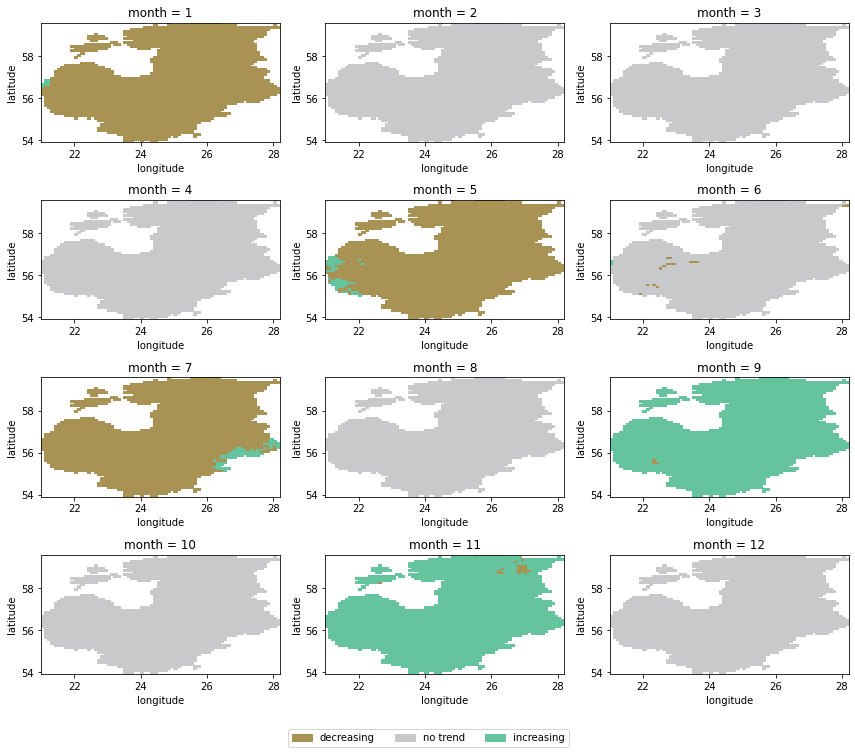

In [58]:
# Dictionary for legend elements
legend_dict = collections.OrderedDict([])

# Three trend classes
classes = ['decreasing', 'no trend', 'increasing']

# Colors used for the classes
colors = ['#A89355', '#C8C9CA', '#65C39E']

# Matplotlib colormap
cmap = matplotlib.colors.ListedColormap(colors)

# Update legend with the trend classes and corresponding colors
for cl, color in zip(classes, colors):
    legend_dict.update({cl: color})

# Matplotlib color patches to be used in the legend
patches = []
for cl in legend_dict:
    patch = mpatches.Patch(color=legend_dict[cl], label=cl)
    patches.append(patch)

# List of months in Dataset
months = precip_array['month']

# Create figure and iterate over months to plot the existence of trends in cells
fig, axes = plt.subplots(4, 3, figsize=(12, 10))
for month, ax in zip(months, axes.flatten()):
    ds = precip_array.sel(month=month)
    ds['trend_numeric'].plot(ax=ax, cmap=cmap, add_colorbar=False)
fig.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3)
fig.tight_layout()

# Save figure
# plt.savefig(os.path.join(data_dir, 'precip_trend_plot.png'), dpi=300, bbox_inches='tight', pad_inches=0)

We can see that trends can be detected in five different months. Majority of cells showed a decreasing trend in January, May and July meaning that it rains less now than it did in the beginning of the study period. An increasing trend can be seen in the case of September and November.

The spatial pattern of trends is also fairly uniform. With some exceptions mainly in the border cells of the study area (e.g. the coast of Lithuania in July), similar changes in precipitation amounts were present in all three countries. Similarity in trend patterns can be explained by the relatively small size of the study area (175,015 km<sup>2</sup>) and the flat terrain of the Baltic states.

In [42]:
df = precip_group_df.copy()

from sklearn import preprocessing

df['slope_abs'] = df['slope'].apply(abs)
normalized_arr = preprocessing.normalize([df['slope_abs'].values])
df['slope_norm'] = normalized_arr[0]

minx = df['slope_abs'].min()
maxx = df['slope_abs'].max()
scale = 4
df['slope_norm_man'] = 1 + ( df['slope_abs'].values - minx ) / ( maxx - minx ) * scale

import mapclassify as mc

clf = mc.NaturalBreaks.make(k=20)

df['slope_norm_class'] = 1 + df[['slope_norm_man']].apply(clf)
df[['slope_norm', 'slope_norm_man', 'slope_norm_class']].describe()

,slope_norm,slope_norm_man,slope_norm_class
count,30564.000000,30564.000000,30564.000000
mean,0.004390,1.639797,6.722353
std,0.003667,0.534534,4.593924
min,0.000000,1.000000,1.000000
25%,0.001546,1.225286,3.000000
50%,0.003430,1.499888,6.000000
75%,0.006264,1.912952,10.000000
max,0.027444,5.000000,20.000000


In [43]:
# Convert the DataFrame back to xarray Dataset
df.set_index(['latitude', 'longitude', 'month'], inplace=True)
slope_array = df.to_xarray()
slope_array

<xarray.Dataset>
Dimensions:           (latitude: 57, longitude: 72, month: 12)
Coordinates:
  * latitude          (latitude) float64 53.95 54.05 54.15 ... 59.35 59.45 59.55
  * longitude         (longitude) float64 21.05 21.15 21.25 ... 28.05 28.15
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip_sum        (latitude, longitude, month) object nan nan ... nan nan
    trend             (latitude, longitude, month) object nan nan ... nan nan
    slope             (latitude, longitude, month) float64 nan nan ... nan nan
    trend_numeric     (latitude, longitude, month) float64 nan nan ... nan nan
    slope_abs         (latitude, longitude, month) float64 nan nan ... nan nan
    slope_norm        (latitude, longitude, month) float64 nan nan ... nan nan
    slope_norm_man    (latitude, longitude, month) float64 nan nan ... nan nan
    slope_norm_class  (latitude, longitude, month) float64 nan nan ... nan nan

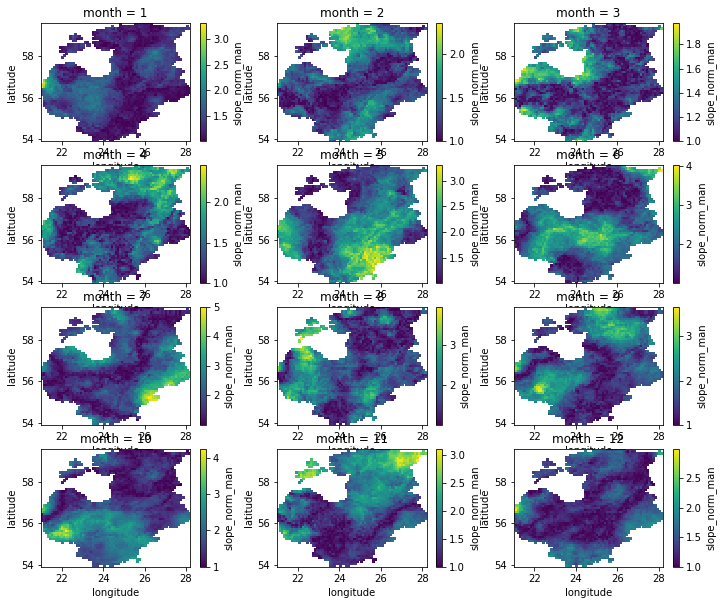

In [45]:
# Iterate over months and visualize the existence of trends
months = slope_array['month']
levels = [-1, 0, 1]
cmap = colors.ListedColormap(['lightblue', 'grey', 'darkblue'])
bounds = [-1, 0, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)
fig, axes = plt.subplots(4, 3, figsize=(12, 10))
for month, ax in zip(months, axes.flatten()):
    ds = slope_array.sel(month=month)
    ds['slope_norm_man'].plot(ax=ax)
    ax.set_aspect('equal')